# Design Project 4: Drone (Quadrotor)

This is the notebook that contains the code used to design, implement and test the control system for the project.

In [1]:
import os

# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import sympy as sym

# This is my own script (it is an interface to the pybullet simulator)
import ae353_drone

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_drone)

<module 'ae353_drone' from 'c:\\Users\\anshu\\Desktop\\Class Materials\\AE 353 Git\\ae353-sp21\\projects\\04_drone\\ae353_drone.py'>

## Equations of Motion

We first work on deriving the equations of motion (given in the problem statement)

In [2]:
# Constants
m = sym.nsimplify(0.5)
J1 = sym.nsimplify(0.0023)
J2 = sym.nsimplify(0.0023)
J3 = sym.nsimplify(0.0040)
l = sym.nsimplify(0.175)
g = sym.nsimplify(9.81)

# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# roll, pitch, yaw angles (radians)
phi, theta, psi = sym.symbols('phi, theta, psi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(0.5)
Jx = sym.nsimplify(0.0023)
Jy = sym.nsimplify(0.0023)
Jz = sym.nsimplify(0.0040)
l = sym.nsimplify(0.175)
g = sym.nsimplify(9.81)

# rotation matrices
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Rxyz = Rx * Ry * Rz

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry * Rz).T * ex, Rz.T * ey, ez).inv(), full=True)

# applied forces
forces = sym.Matrix([[0], [0], [-m * g]]) + Rxyz * sym.Matrix([[0], [0], [f_z]])

# euler's equations
euler = sym.Matrix([[(1 / Jx) * (tau_x + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (tau_y + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (tau_z + (Jx - Jy) * w_x * w_y)]])

# equations of motion
f = sym.Matrix.vstack(sym.Matrix([[v_x], [v_y], [v_z]]),
                      M * sym.Matrix([[w_x], [w_y], [w_z]]),
                      (1 / m) * forces,
                      euler)
f = sym.simplify(f, full=True)

_f_ gives us the derivative of the state vector as a function of the states and the inputs
$$f = \dot{x}$$
Here, the state is the following vector:

$$\begin{bmatrix} p_x \\ p_y \\ p_z \\ \phi \\ \theta \\ \psi \\ v_x \\ v_y \\ v_z \\ w_x \\ w_y \\ w_z \end $$

In [3]:
f

Matrix([
[                                                     v_x],
[                                                     v_y],
[                                                     v_z],
[                (w_x*cos(psi) - w_y*sin(psi))/cos(theta)],
[                             w_x*sin(psi) + w_y*cos(psi)],
[-w_x*cos(psi)*tan(theta) + w_y*sin(psi)*tan(theta) + w_z],
[                                        2*f_z*sin(theta)],
[                              -2*f_z*sin(phi)*cos(theta)],
[                     2*f_z*cos(phi)*cos(theta) - 981/100],
[                          10000*tau_x/23 - 17*w_y*w_z/23],
[                          10000*tau_y/23 + 17*w_x*w_z/23],
[                                               250*tau_z]])

We then create a numeric function for _f_ to check our equilibrium values

In [4]:
# Numeric function for f
f_num = sym.lambdify((v_x, v_y, v_z,phi, theta, psi, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), f)

In [5]:
# These are all the equilibrium values for the system. Note the non-zero value for the z force
v_x_e = 0
v_y_e = 0
v_z_e = 0
p_x_e = 0
p_y_e = 0
p_z_e = 0
phi_e = 0
theta_e = 0
psi_e = 0
w_x_e = 0
w_y_e = 0
w_z_e = 0
tau_x_e = 0
tau_y_e = 0
tau_z_e = 0
f_z_e = 9.81/2

In [6]:
# Now we can check if the equilibrium point works
f_num(v_x_e, v_y_e, v_z_e, phi_e, theta_e, psi_e, w_x_e, w_y_e, w_z_e, tau_x_e, tau_y_e, tau_z_e, f_z_e) # == 0? Yes!

array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [-0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

## Linearizing the system

We now linearize the system about the equilibrium point to find A and B. The Jacobian is taken with respect to the state for A and with respect to the inputs for B

In [7]:
## Jacobians
f_jacob_x = f.jacobian([p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z])
f_jacob_u = f.jacobian([tau_x, tau_y, tau_z, f_z])

# Lambda functions
A_num = sym.lambdify((p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z),f_jacob_x)
B_num = sym.lambdify((p_x, p_y, p_z, phi, theta, psi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z),f_jacob_u)

#Values at equilibrium
A = A_num(p_x_e, p_y_e, p_z_e, phi_e, theta_e, psi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, tau_x_e, tau_y_e, tau_z_e, f_z_e)
B = B_num(p_x_e, p_y_e, p_z_e, phi_e, theta_e, psi_e, v_x_e, v_y_e, v_z_e, w_x_e, w_y_e, w_z_e, tau_x_e, tau_y_e, tau_z_e, f_z_e)


In [8]:
# See A
A

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         1.  , -0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        -0.  ,  0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  9.81,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -9.81,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  , -0.  

In [9]:
# See B
B

array([[  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,   0.       ],
       [  0.       ,   0.       ,   0.       ,  -0.       ],
       [  0.       ,   0.       ,   0.       ,   2.       ],
       [434.7826087,   0.       ,   0.       ,   0.       ],
       [  0.       , 434.7826087,   0.       ,   0.       ],
       [  0.       ,   0.       , 250.       ,   0.       ]])

In [10]:
# Checking for controllability
# Find the number of states
n = A.shape[0]

# Initialize W with its first column
Wc = B

# Create W one column at a time by iterating over i from 1 to n-1
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    Wc = np.block([Wc, col])
# What about the rank?
print(np.linalg.matrix_rank(Wc))
#Rank is 12, same as the number of variables. Nice!

12


## Sensor Model
We know that we are getting the position and orientation data from the sensors. This directly co-relates to our state variables. So, we can define the C matrix as shown below:

In [11]:
C = np.array([[1,0,0,0,0,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,0,0,0,0,0,0],
              [0,0,1,0,0,0,0,0,0,0,0,0],
              [0,0,0,1,0,0,0,0,0,0,0,0],
              [0,0,0,0,1,0,0,0,0,0,0,0],
              [0,0,0,0,0,1,0,0,0,0,0,0]])

In [12]:
# We can check for the observability of this system
Wo = C
for i in range(1,n):
    row = C @ np.linalg.matrix_power(A,i)
    Wo = np.block([[Wo],[row]])
rank = np.linalg.matrix_rank(Wo)
print(rank)
# The rank of the system is the same as the number of states, so the system is observable.

12


## Optimal Controller and Observer

With a linearized system, we can now find optimal controllers and observers. A lot of tuning went into developing this controller. Beyond this controller, additional conditionals are used in the controller design that can be seen in the main RobotController class. See the report for details about the choices.

In [13]:
Qc = np.diag([5.,25.,5.,24.,24.,24.,4.,8.,4.,8.,8.,8.]) 
Rc = np.diag([70.,70.,70.,2.])
# We can also define an LQR function in the following way:
def lqr(A,B,Q,R):
    P = linalg.solve_continuous_are(A,B,Q,R)
    K = linalg.inv(R) @ B.T @ P
    return K
# The function above can be used for both controller and observer design

# Designing an optimal observer
Qo = 100*np.diag(np.ones(6))
Ro = np.diag(np.ones(12))

L = lqr(A.T, C.T, linalg.inv(Ro), linalg.inv(Qo)).T

K = lqr(A,B,Qc,Rc)
print(K)
print(L)

[[-7.47010382e-16 -5.97614305e-01 -2.53473645e-16  2.13127925e+00
  -2.27950886e-15  1.21742135e-14 -5.72576646e-16 -6.11519455e-01
   2.12358588e-16  3.52263536e-01  1.88230452e-17  9.77728258e-17]
 [ 2.67261242e-01 -2.96364683e-17  3.33836675e-16 -4.68728990e-16
   1.73242685e+00  4.03400058e-17  3.89279442e-01  4.40312352e-16
   3.99656769e-18  1.88230452e-17  3.49649650e-01 -3.70848823e-17]
 [-2.40839428e-16 -9.45256955e-15 -1.62359357e-16  9.56049283e-15
   7.26727242e-16  5.85540044e-01  1.08732360e-16 -3.63425917e-15
  -9.55325335e-17  5.62193748e-17 -2.13238073e-17  3.44920331e-01]
 [-8.42370322e-17 -1.18120552e-15  1.58113883e+00  1.75455407e-15
  -7.34140509e-16 -7.78219546e-16 -2.31994994e-16 -1.01435939e-15
   1.89238971e+00  3.41897327e-17  6.43447398e-19 -2.67491094e-17]]
[[11.30588031  0.          0.          0.          0.43967768  0.        ]
 [ 0.         11.30588031  0.         -0.43967768  0.          0.        ]
 [ 0.          0.         10.95445115  0.          0.

In [14]:
# Check that both the controller and observer are stable
Fo = A - L@C
so = linalg.eigvals(Fo)
if (so.real < 0).all():
    print("Observer is stable")
    print(so)

Fc = A - B@K
sc = linalg.eigvals(Fc)
if (sc.real < 0).all():
    print("Controller is stable")
    print(sc)

Observer is stable
[-10.41413987+0.j  -9.40751399+0.j  -1.42977947+0.j  -1.00005092+0.j
 -10.41413987+0.j  -9.40751399+0.j  -1.42977947+0.j  -1.00005092+0.j
  -9.94936153+0.j  -9.94936153+0.j  -1.00508962+0.j  -1.00508962+0.j]
Controller is stable
[-146.97314922+0.j         -146.9731568 +0.j
  -84.49766791+0.j           -1.95187893+1.72217394j
   -1.95187893-1.72217394j   -1.1446799 +0.j
   -2.21018118+2.22344801j   -2.21018118-2.22344801j
   -2.53958456+0.j           -1.24519487+0.j
   -1.76453999+0.j           -1.73241481+0.j        ]


## Simulation

In [15]:
simulator = ae353_drone.Simulator(display=False, pos_noise = 0.1, rpy_noise = 0.1, seed = 42)

## Defining the Controller

The controller below is the large chunk of this project. It not only has the K and L gains used before, but it also implements its own logic for trajectory tracking.

In [16]:
x_des_array = []

In [17]:
class RobotController:
    def __init__(self, limiter=None):
        self.dt = 0.01
        self.limiter = limiter
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L
        self.f_z_e = f_z_e

    def get_color(self):
        return [1., 0., 0.]

    def reset(self, pos):
        self.xhat = np.array([[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.],[0.]])


    def run(self, pos, rpy, pos_ring, is_last_ring, pos_others):
        offset = -0.4
        y = np.array([[pos[0]], [pos[1]], [pos[2]], [rpy[0]], [rpy[1]], [rpy[2]]])
        dist = linalg.norm([[pos_ring[0] + offset - pos[0]], [pos_ring[1] - pos[1]], [pos_ring[2] - pos[2]]])
        displace_vec = ([[pos_ring[0] + offset - pos[0]], [pos_ring[1] - pos[1]], [pos_ring[2] - pos[2]]])/dist
        if dist < 1.:
            v_vect = np.array([[1.2], [0.], [0.]])
        else:
            v_vect = displace_vec * (dist)**2 * 0.06
    
        x_des = np.array([[pos_ring[0] + offset],[pos_ring[1]],[pos_ring[2]],[0.],[0.],[0.],[v_vect[0,0]],[v_vect[1,0]],[v_vect[2,0]],[0.],[0.],[0.]])
        if is_last_ring:
            x_des[2,0] += 0.4

        max_error = 1.4

        for i in range(12):
            if np.abs(x_des[i,0] - self.xhat[i,0]) > max_error:
                x_des[i,0] = self.xhat[i,0] + max_error * ((x_des[i,0] - self.xhat[i,0]) / linalg.norm(x_des[i,0] - self.xhat[i,0]))
        
        x_des_array.append(x_des)

        u = -self.K @ (self.xhat - x_des)
        tau_x = u[0,0]
        tau_y = u[1,0]
        tau_z = u[2,0]
        if y[2,0] <= 0.5:
            u[3,0] = 2.5
        if is_last_ring:
            if abs(pos_ring[0] - pos[0]) < 0.6 and abs(pos_ring[1] - pos[1]) < 0.6:
                u[3,0] = -100.
        f_z = u[3,0] + self.f_z_e
        if self.limiter is not None:
            tau_x, tau_y, tau_z, f_z = self.limiter(tau_x, tau_y, tau_z, f_z)
        u[3,0] = f_z - self.f_z_e
        self.xhat += self.dt * (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y))

        return tau_x, tau_y, tau_z, f_z

### Running the simulation once
Running the simulation just one time can get us quick data and good plots that describe how our controller and observer are performing. The display can also be turned on, as was done often, to get a visual understanding of the errors occuring.

In [18]:
simulator.clear_drones()
simulator.add_drone(RobotController, 'anshukc2', 'anshukc2.png')
simulator.camera_droneview('anshukc2')
simulator.move_rings()
simulator.reset()
simulator.run(max_time=30.0)
drone_name = 'anshukc2'
drone = simulator.get_drone_by_name(drone_name)
data = drone['data'].copy()
for key in data.keys():
    data[key] = np.array(data[key]).T
x_des_array = np.array(x_des_array)

### Plotting Data
The plots shown below are all the different ones used when analyzing the system. Not all of these are included in the report as it would take up a lot of space

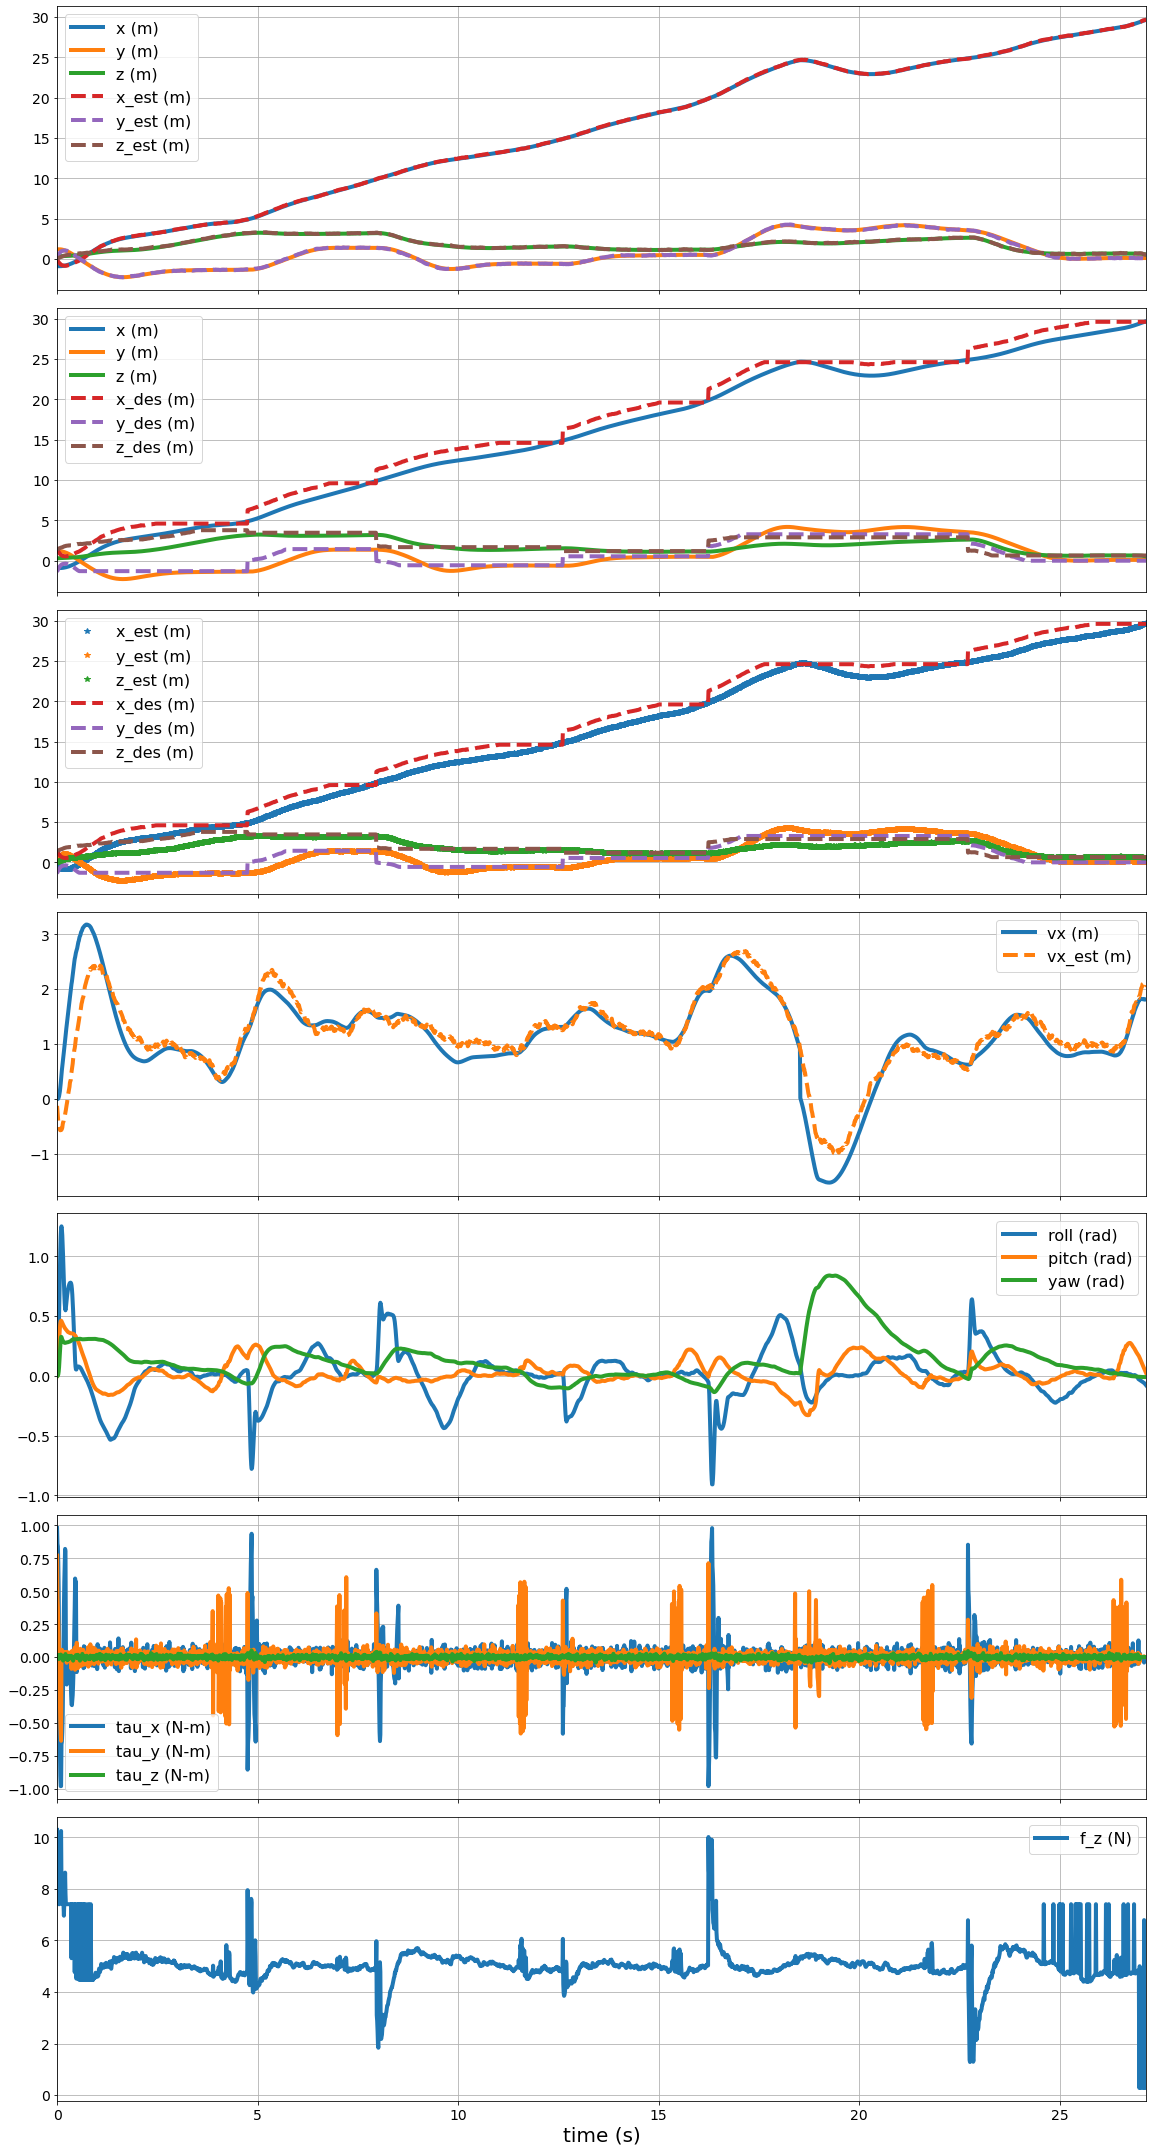

In [19]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_pos, ax_d, ax_d2, ax_v, ax_rpy, ax_taus, ax_fz) = plt.subplots(7, 1, figsize=(16, 30), sharex=True)

# Position
ax_pos.plot(data['t'], data['pos'][0, :], label='x (m)', linewidth=4)
ax_pos.plot(data['t'], data['pos'][1, :], label='y (m)', linewidth=4)
ax_pos.plot(data['t'], data['pos'][2, :], label='z (m)', linewidth=4)
ax_pos.plot(data['t'], data['xhat'][0, :], '--', label='x_est (m)', linewidth=4)
ax_pos.plot(data['t'], data['xhat'][1, :], '--', label='y_est (m)', linewidth=4)
ax_pos.plot(data['t'], data['xhat'][2, :], '--', label='z_est (m)', linewidth=4)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)


# Desired
ax_d.plot(data['t'], data['pos'][0, :], label='x (m)', linewidth=4)
ax_d.plot(data['t'], data['pos'][1, :], label='y (m)', linewidth=4)
ax_d.plot(data['t'], data['pos'][2, :], label='z (m)', linewidth=4)
ax_d.plot(data['t'], x_des_array[:,0,0], '--', label='x_des (m)', linewidth=4)
ax_d.plot(data['t'], x_des_array[:,1,0], '--', label='y_des (m)', linewidth=4)
ax_d.plot(data['t'], x_des_array[:,2,0], '--', label='z_des (m)', linewidth=4)
ax_d.grid()
ax_d.legend(fontsize=16)
ax_d.tick_params(labelsize=14)

# Desired vs Estimate
ax_d2.plot(data['t'], data['xhat'][0, :], '*', label='x_est (m)', linewidth=4)
ax_d2.plot(data['t'], data['xhat'][1, :], '*', label='y_est (m)', linewidth=4)
ax_d2.plot(data['t'], data['xhat'][2, :], '*', label='z_est (m)', linewidth=4)
ax_d2.plot(data['t'], x_des_array[:,0,0], '--', label='x_des (m)', linewidth=4)
ax_d2.plot(data['t'], x_des_array[:,1,0], '--', label='y_des (m)', linewidth=4)
ax_d2.plot(data['t'], x_des_array[:,2,0], '--', label='z_des (m)', linewidth=4)
ax_d2.grid()
ax_d2.legend(fontsize=16)
ax_d2.tick_params(labelsize=14)


#Velocity
ax_v.plot(data['t'], data['linvel'][0, :], label='vx (m)', linewidth=4)
# ax_v.plot(data['t'], data['linvel'][1, :], label='vy (m)', linewidth=4)
# ax_v.plot(data['t'], data['linvel'][2, :], label='vz (m)', linewidth=4)
ax_v.plot(data['t'], data['xhat'][6, :], '--', label='vx_est (m)', linewidth=4)
# ax_v.plot(data['t'], data['xhat'][7, :], '--', label='vy_est (m)', linewidth=4)
# ax_v.plot(data['t'], data['xhat'][8, :], '--', label='vz_est (m)', linewidth=4)
ax_v.grid()
ax_v.legend(fontsize=16)
ax_v.tick_params(labelsize=14)


# Roll, pitch, and yaw angles
ax_rpy.plot(data['t'], data['rpy'][0, :], label='roll (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][1, :], label='pitch (rad)', linewidth=4)
ax_rpy.plot(data['t'], data['rpy'][2, :], label='yaw (rad)', linewidth=4)
ax_rpy.grid()
ax_rpy.legend(fontsize=16)
ax_rpy.tick_params(labelsize=14)

# Actuator commands
ax_taus.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_taus.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_taus.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_taus.grid()
ax_taus.legend(fontsize=16)
ax_taus.tick_params(labelsize=14)

# Force command 
ax_fz.plot(data['t'], data['f_z'], label='f_z (N)', linewidth=4)
ax_fz.grid()
ax_fz.legend(fontsize=16)
ax_fz.tick_params(labelsize=14)

# Set shared x-axis properties
ax_fz.set_xlabel('time (s)', fontsize=20)
ax_fz.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

### Plots for the report
These are the plots that are actually used in the report


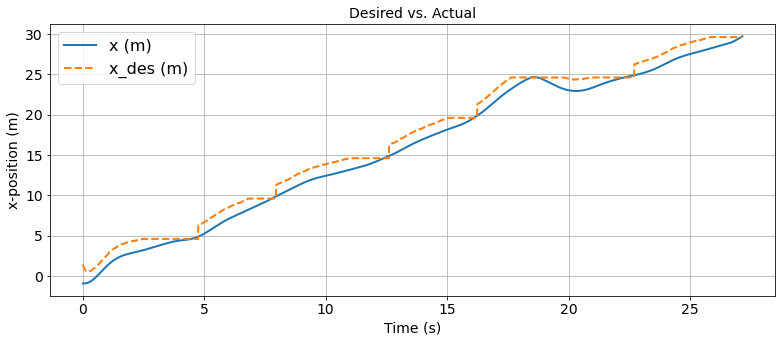

In [20]:
#Plot for the position vs desired position
plt.figure(figsize=(13,5))
plt.plot(data['t'], data['pos'][0, :], label='x (m)', linewidth=2)
plt.plot(data['t'], x_des_array[:,0,0], '--', label='x_des (m)', linewidth=2)
plt.grid()
plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("x-position (m)", fontsize=14)
plt.title("Desired vs. Actual", fontsize=14)
plt.show()

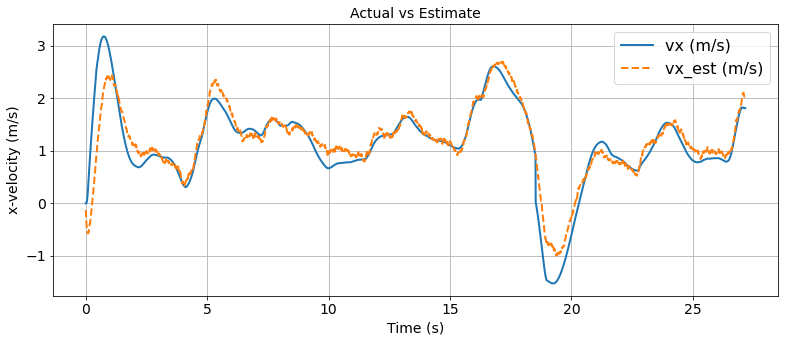

In [21]:
# Plot for the velocity vs estimate
plt.figure(figsize=(13,5))
plt.plot(data['t'], data['linvel'][0, :], label='vx (m/s)', linewidth=2)
plt.plot(data['t'], data['xhat'][6, :], '--', label='vx_est (m/s)', linewidth=2)
plt.grid()
plt.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("x-velocity (m/s)", fontsize=14)
plt.title("Actual vs Estimate", fontsize=14)
plt.show()

### Running the Simulation many times
With the controller defined, we can now run the simulation as many times as we want. To get aggregate results, we reset the simulator, and move the rings to get a new simulation.

In [22]:
num_iters = 500
finished = 0
failed = 0
finish_times = np.zeros(num_iters) - np.ones(num_iters)
print("-------Starting Simulations!--------")
for i in range(num_iters):
    simulator.clear_drones()
    simulator.add_drone(RobotController, 'anshukc2', 'anshukc2.png')
    simulator.camera_droneview('anshukc2')
    simulator.move_rings()
    simulator.reset()
    x_des_array = []
    simulator.run(max_time=70.0)
    drone_name = 'anshukc2'
    drone = simulator.get_drone_by_name(drone_name)
    if drone['finish_time'] is None:
        failed += 1
    else:
        finished += 1
        finish_times[i] = drone['finish_time']
    if i%10 == 0:
        print(f"{i} /", num_iters)
print(num_iters, f" /", num_iters)
print("---------Simulations Complete!-------")

-------Starting Simulations!--------
0 / 500
10 / 500
20 / 500
30 / 500
40 / 500
50 / 500
60 / 500
70 / 500
80 / 500
90 / 500
100 / 500
110 / 500
120 / 500
130 / 500
140 / 500
150 / 500
160 / 500
170 / 500
180 / 500
190 / 500
200 / 500
210 / 500
220 / 500
230 / 500
240 / 500
250 / 500
260 / 500
270 / 500
280 / 500
290 / 500
300 / 500
310 / 500
320 / 500
330 / 500
340 / 500
350 / 500
360 / 500
370 / 500
380 / 500
390 / 500
400 / 500
410 / 500
420 / 500
430 / 500
440 / 500
450 / 500
460 / 500
470 / 500
480 / 500
490 / 500
500  / 500
---------Simulations Complete!-------


### Extracting Finish Data and Report

In [23]:
actual_finish_times = []
for i in range(len(finish_times)):
    if finish_times[i] >= 0:
         actual_finish_times.append(finish_times[i])
actual_finish_times = np.array(actual_finish_times)

------------------Report----------------
Total number of runs:           500
No. of successful runs:         461
No. of failed runs:             39
Success rate:                   92.2
Mean finish time:               28.804251626898047
Median finish time:             27.87
Standard Deviation:             4.956736923202393


-----Histogram of all finish times------



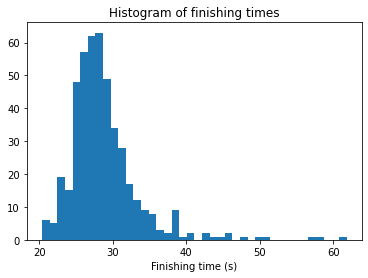

In [27]:
# A nicely formatted report, inspired by Alan Hong's even nicer formatted report
print("------------------Report----------------")
print(f"Total number of runs:          ", num_iters)
print(f"No. of successful runs:        ", finished)
print(f"No. of failed runs:            ", failed)
print(f"Success rate:                  ", finished/num_iters * 100)
print(f"Mean finish time:              ", np.mean(actual_finish_times))
print(f"Median finish time:            ",np.median(actual_finish_times))
print(f"Standard Deviation:            ", np.std(actual_finish_times))
print(f"\n\n-----Histogram of all finish times------\n")
plt.hist(actual_finish_times, bins= 40)
plt.xlabel("Finishing time (s)")
plt.title("Histogram of finishing times")
plt.show()

## Conclusion
From the report above we see that the results are not as useful as wanted by the requirement. This is discussed in greater detail in the report, but the idea is that using desired velocities in the way used in this controller leads to a large amount of momentum that often results in hitting the hoops or overshooting. Although preventive measures were taken, the error still persists.